# Phase 1: Naive Monte Carlo Simulation

This notebook implements the naive Monte Carlo approach for estimating transition probabilities in the double well potential system.

## Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import sys
import os

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import our modules
from potentials import double_well_potential, double_well_gradient, create_potential_grid
from integrators import euler_maruyama_step, euler_maruyama_trajectory
from detectors import in_region_A, in_region_B, check_absorption, simulate_until_absorption
from monte_carlo import run_naive_mc, print_results_summary
from utils import plot_potential_field, plot_trajectory, plot_absorption_time_histogram, save_figure

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

## 1. System Visualization

First, let's visualize the double well potential and the regions A and B.

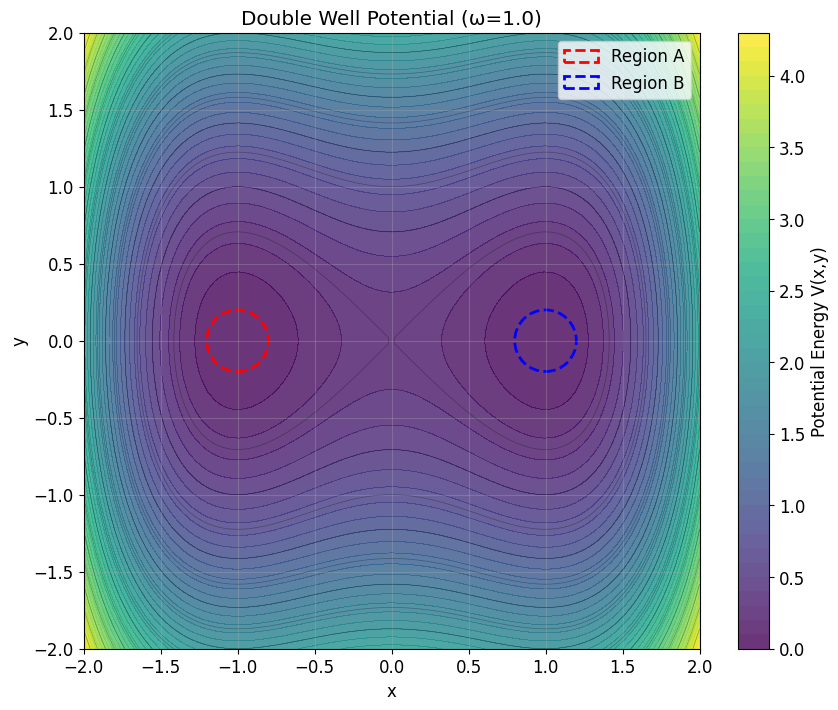

Figure saved to experiments/figures/double_well_potential.png


In [33]:
# Plot the potential field
fig, ax = plot_potential_field(omega=1.0, show_regions=True, r_A=0.2, r_B=0.2)
plt.show()
# Save the figure
save_figure(fig, 'double_well_potential')

## 2. Test Trajectories

Let's simulate 1000 trajectories to understand the dynamics.

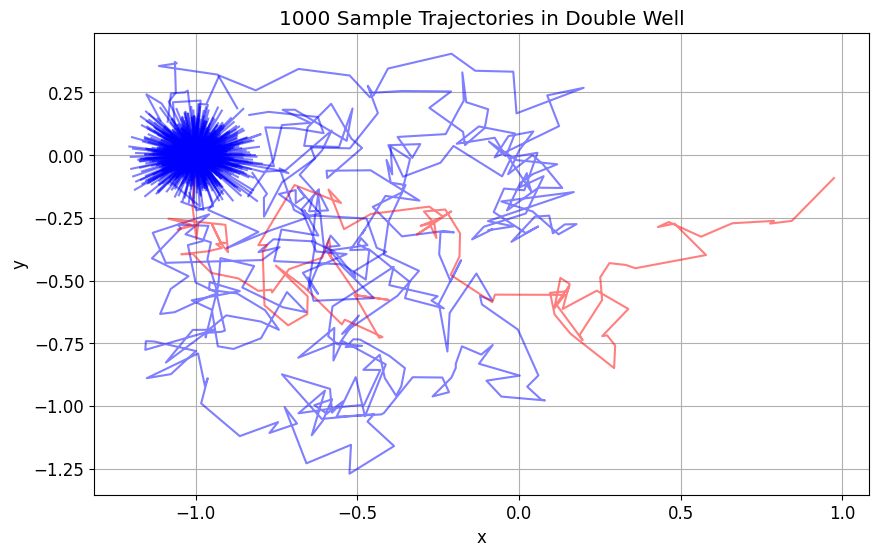

Figure saved to experiments/figures/multiple_trajectories.png


In [56]:
n_traj = 1000
beta_inv = 0.3
trajectories = []
abs_count = {0: 0, 1: 0, 2: 0}
x0, y0 = -1.0, 0.0
dt = 0.01
max_steps = 1000
omega = 1.0

fig, ax = plt.subplots()
for _ in range(n_traj):
    traj, state, _ = simulate_until_absorption(x0, y0, dt, beta_inv, max_steps, omega)
    trajectories.append(traj)
    abs_count[state] += 1

    if state == 1:
        traj_color = 'blue'
    elif state == 2:
        traj_color = 'red'
    else:
        traj_color = 'green'
        
    ax.plot(traj[:, 0], traj[:, 1], color=traj_color, alpha=0.5)

ax.set_title(f"{n_traj} Sample Trajectories in Double Well")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

save_figure(fig, 'multiple_trajectories')


## 3. Naive Monte Carlo Simulation

Now let's run multiple simulations to estimate the transition probability $p = \mathbb{P}(\tau_B < \tau_A)$.

In [60]:
# Parameters for Monte Carlo simulation
n_simulations = 10000
x0, y0 = -1.0, 0.0  # Start in left well
dt = 0.01
beta_inv = 0.3
max_steps = 10000
omega = 1.0

print("Running naive Monte Carlo simulation...")
results = run_naive_mc(n_simulations, x0, y0, dt, beta_inv, max_steps, 
                       omega=omega)

print_results_summary(results)

Running naive Monte Carlo simulation...


Running MC simulations: 100%|██████████| 10000/10000 [00:00<00:00, 193993.93it/s]

NAIVE MONTE CARLO SIMULATION RESULTS
Number of simulations: 10000
Absorbed in A: 9994 (99.94%)
Absorbed in B: 6 (0.06%)
Unabsorbed: 0 (0.00%)

Estimated p = P(τ_B < τ_A) = 0.000600
95% Confidence Interval: [0.000281, 0.001305]

Mean absorption time for B: 193.50 steps
Std absorption time for B: 130.78 steps
Mean absorption time for A: 1.22 steps
Std absorption time for A: 4.77 steps


## 4. Visualization of Results

Let's visualize the distribution of absorption times.

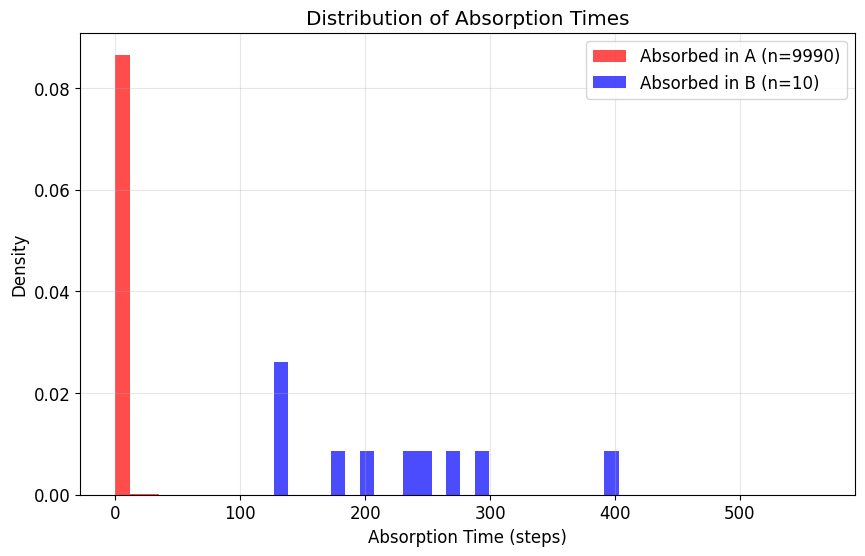

Figure saved to experiments/figures/absorption_time_histogram.png


In [36]:
# Plot absorption time histogram
fig, ax = plot_absorption_time_histogram(results)
plt.show()

save_figure(fig, 'absorption_time_histogram')

## 5. Study of Time Step Δt

Let's investigate the effect of different time steps on the results.

In [61]:
dt_values = [0.001, 0.005, 0.01, 0.05]
n_simulations_dt = 10000 

dt_results = {}

for dt in tqdm(dt_values, desc="Testing different Δt"):
    results_dt = run_naive_mc(n_simulations_dt, x0, y0, dt, beta_inv, max_steps, 
                             omega=omega)
    dt_results[dt] = results_dt

# Print results for comparison
print("\nComparison of results for different time steps:")
print("=" * 60)
for dt, res in dt_results.items():
    print(f"Δt = {dt:.4f}: p = {res['p_estimate']:.6f} "
          f"CI95: [{res['ci_95'][0]:.6f}, {res['ci_95'][1]:.6f}]")
    print(f"         B transitions: {res['n_B']}/{n_simulations_dt}")

Testing different Δt: 100%|██████████| 4/4 [00:00<00:00, 18.15it/s]


Comparison of results for different time steps:
Δt = 0.0010: p = 0.000000 CI95: [0.000000, 0.000299]
         B transitions: 0/10000
Δt = 0.0050: p = 0.000000 CI95: [0.000000, 0.000299]
         B transitions: 0/10000
Δt = 0.0100: p = 0.000200 CI95: [0.000062, 0.000722]
         B transitions: 2/10000
Δt = 0.0500: p = 0.023300 CI95: [0.020525, 0.026447]
         B transitions: 233/10000


## 6. Study of Temperature (β⁻¹)

Let's investigate how temperature affects the transition probability.

In [62]:
beta_inv_values = [0.1, 0.3, 0.5, 0.7, 1.0]
n_simulations_temp = 10000
print(f"value of time step dt: {dt}")

temp_results = {}

for beta_inv in tqdm(beta_inv_values, desc="Testing different temperatures"):
    results_temp = run_naive_mc(n_simulations_temp, x0, y0, dt, beta_inv, max_steps, 
                               omega=omega)
    temp_results[beta_inv] = results_temp

# Print results for comparison
print("\nComparison of results for different temperatures:")
print("=" * 70)
for beta_inv, res in temp_results.items():
    print(f"β⁻¹ = {beta_inv:.2f}: p = {res['p_estimate']:.6f} "
          f"CI95: [{res['ci_95'][0]:.6f}, {res['ci_95'][1]:.6f}]")
    print(f"           B transitions: {res['n_B']}/{n_simulations_temp}")

value of time step dt: 0.05


Testing different temperatures: 100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Comparison of results for different temperatures:
β⁻¹ = 0.10: p = 0.000900 CI95: [0.000480, 0.001708]
           B transitions: 9/10000
β⁻¹ = 0.30: p = 0.023400 CI95: [0.020618, 0.026553]
           B transitions: 234/10000
β⁻¹ = 0.50: p = 0.057900 CI95: [0.053493, 0.062652]
           B transitions: 579/10000
β⁻¹ = 0.70: p = 0.090900 CI95: [0.085424, 0.096694]
           B transitions: 909/10000
β⁻¹ = 1.00: p = 0.124100 CI95: [0.117784, 0.130709]
           B transitions: 1241/10000


## 7. Summary and Conclusions

Let's create a summary table of our findings.

In [39]:
print("SUMMARY OF NAIVE MONTE CARLO RESULTS")
print("=" * 50)
print(f"Base parameters: ω={omega}, x0=({x0},{y0}), max_steps={max_steps}")
print()

# Main result
print("Main simulation (n=1000, dt=0.01, β⁻¹=0.5):")
print(f"  p = {results['p_estimate']:.6f}")
print(f"  95% CI: [{results['ci_95'][0]:.6f}, {results['ci_95'][1]:.6f}]")
print()

# Time step study
print("Time step study (n=500, β⁻¹=0.5):")
for dt, res in dt_results.items():
    print(f"  Δt={dt:.4f}: p={res['p_estimate']:.6f}")
print()

# Temperature study
print("Temperature study (n=500, dt=0.01):")
for beta_inv, res in temp_results.items():
    print(f"  β⁻¹={beta_inv:.2f}: p={res['p_estimate']:.6f}")
print()

print("Conclusions:")
print("- The naive MC method provides reliable estimates for measurable probabilities")
print("- The method becomes inefficient for very rare events (p < 10^-3)")
print("- This motivates the need for more advanced methods like AMS")

SUMMARY OF NAIVE MONTE CARLO RESULTS
Base parameters: ω=1.0, x0=(-1.0,0.0), max_steps=10000

Main simulation (n=1000, dt=0.01, β⁻¹=0.5):
  p = 0.001000
  95% CI: [0.000549, 0.001838]

Time step study (n=500, β⁻¹=0.5):
  Δt=0.0010: p=0.000000
  Δt=0.0050: p=0.000000
  Δt=0.0100: p=0.000200
  Δt=0.0500: p=0.027200

Temperature study (n=500, dt=0.01):
  β⁻¹=0.10: p=0.000400
  β⁻¹=0.30: p=0.025400
  β⁻¹=0.50: p=0.056500
  β⁻¹=0.70: p=0.088800
  β⁻¹=1.00: p=0.135000

Conclusions:
- The naive MC method provides reliable estimates for measurable probabilities
- The method becomes inefficient for very rare events (p < 10^-3)
- This motivates the need for more advanced methods like AMS


## 8. Save Results

Save the simulation results for future reference.

In [40]:
import json
import pickle

# Create results directory
os.makedirs('../experiments/results', exist_ok=True)

# Save main results as JSON
with open('../experiments/results/naive_mc_main.json', 'w') as f:
    json.dump({
        'parameters': {
            'n_simulations': n_simulations,
            'x0': x0, 'y0': y0,
            'dt': dt, 'beta_inv': beta_inv,
            'max_steps': max_steps,
            'omega': omega,
        },
        'results': {
            'p_estimate': float(results['p_estimate']),
            'ci_95': [float(results['ci_95'][0]), float(results['ci_95'][1])],
            'n_A': int(results['n_A']),
            'n_B': int(results['n_B']),
            'n_unabsorbed': int(results['n_unabsorbed'])
        }
    }, f, indent=2)

# Save full results with pickle
with open('../experiments/results/naive_mc_main.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to experiments/results/")
print("Phase 1 implementation complete!")

Results saved to experiments/results/
Phase 1 implementation complete!
